# Random Forest: Predicting ENVO Local Scale from Google Earth Embeddings

This notebook trains a Random Forest classifier to predict environmental ontology (ENVO) local scale terms from Google Earth Engine satellite embeddings.

**Question**: Can geographic/satellite imagery data predict environmental classification labels?

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Load and Prepare Data

In [2]:
# Load the dataset with error handling
try:
    df = pd.read_csv('../data/satisfying_biosamples_normalized_with_google_embeddings_with_envo_embeddings.csv',
                     on_bad_lines='skip', engine='python')
except Exception as e:
    print(f"Error with python engine, trying with quoting settings: {e}")
    df = pd.read_csv('../data/satisfying_biosamples_normalized_with_google_embeddings_with_envo_embeddings.csv',
                     on_bad_lines='skip', quoting=3)  # quoting=3 is QUOTE_NONE

print(f"Total rows: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Total rows: 10978
Columns: ['accession', 'collection_date', 'env_broad_scale', 'env_local_scale', 'env_medium', 'collection_date_raw', 'lat_lon_raw', 'latitude', 'longitude', 'google_earth_embeddings', 'envo_broad_scale_embedding', 'envo_medium_embedding', 'envo_local_scale_embedding']

First few rows:


,accession,collection_date,env_broad_scale,env_local_scale,env_medium,collection_date_raw,lat_lon_raw,latitude,longitude,google_earth_embeddings,envo_broad_scale_embedding,envo_medium_embedding,envo_local_scale_embedding
0,SAMN17868687,2018-04-18,ENVO:01000200,ENVO:00005778,ENVO:00001998,2018-04-18,21.62997 N 158.04263 W,21.6300,-158.0426,"[0.1085121107266436, -0.041584006151480196, -0...","[0.014217192307114601, 0.018054282292723656, 0...","[0.02584735117852688, 0.017786771059036255, 0....","[0.0022946360986679792, 0.007574582472443581, ..."
1,SAMD00517000,2019-10-30,ENVO:00001998,ENVO:00001998,ENVO:00000035,2019-10-30,26.0294 N 119.6253 E,26.0294,119.6253,"[-0.07535563244905807, -0.019930795847750864, ...","[0.02584735117852688, 0.017786771059036255, 0....","[0.04451766982674599, 0.07730268687009811, 0.0...","[0.02584735117852688, 0.017786771059036255, 0...."
2,SAMN41110369,2022-08-02,ENVO:00000150,ENVO:00000130,ENVO:00002149,2022-08-02,5.074183 S 119.422367 E,-5.0742,119.4224,"[-0.05536332179930796, -0.15378700499807765, -...","[0.019278576597571373, 0.03416483849287033, 0....","[0.011169728823006153, 0.05698113888502121, 0....","[-0.0008939744438976049, 0.0014722641790285707..."
3,SAMN40126579,2020-11-02,ENVO:00000449,ENVO:00002042,ENVO:00002011,2020-11-02,52.1307 N 3.7837 W,52.1307,-3.7837,"[-0.06698961937716265, 0.004982698961937716, -...","[-0.02230525203049183, 0.026067335158586502, 0...","[0.014508732594549656, 0.01091198343783617, 0....","[-0.010581069625914097, 0.0606289878487587, 0...."
4,SAMN10720695,2017-04-01,ENVO:00000111,ENVO:01000768,ENVO:00002261,2017-04,36.898979 S 174.538467 E,-36.8990,174.5385,"[0.14173010380622836, 0.11374086889657825, -0....","[0.0015951043460518122, 0.0006954990676604211,...","[0.011648660525679588, -0.03433772549033165, 0...","[-0.010841501876711845, 0.010913022793829441, ..."


In [3]:
# Check for missing values in key columns
print("Missing values:")
print(df[['google_earth_embeddings', 'env_local_scale']].isna().sum())

# Filter to rows with both embeddings and labels
df_clean = df[df['google_earth_embeddings'].notna() & df['env_local_scale'].notna()].copy()
print(f"\nRows with both Google Earth embeddings and env_local_scale: {len(df_clean)}")

Missing values:
google_earth_embeddings    0
env_local_scale            0
dtype: int64

Rows with both Google Earth embeddings and env_local_scale: 10978


## Parse Embeddings

In [4]:
def parse_embedding(embedding_str):
    """
    Parse embedding string to numpy array.
    
    Args:
        embedding_str: String representation of embedding list
        
    Returns:
        numpy array of embedding values
    """
    try:
        if isinstance(embedding_str, str):
            embedding_list = ast.literal_eval(embedding_str)
        else:
            embedding_list = embedding_str
        return np.array(embedding_list, dtype=np.float32)
    except Exception as e:
        print(f"Error parsing embedding: {e}")
        return None

# Parse Google Earth embeddings
print("Parsing Google Earth embeddings...")
df_clean['ge_embedding'] = df_clean['google_earth_embeddings'].apply(parse_embedding)

# Remove any rows where parsing failed
df_clean = df_clean[df_clean['ge_embedding'].notna()].copy()

print(f"Rows with valid embeddings: {len(df_clean)}")
if len(df_clean) > 0:
    embedding_dim = len(df_clean.iloc[0]['ge_embedding'])
    print(f"Google Earth embedding dimension: {embedding_dim}")

Parsing Google Earth embeddings...
Rows with valid embeddings: 10978
Google Earth embedding dimension: 64


## Explore Target Variable

In [5]:
# Examine env_local_scale values
print("=== TARGET VARIABLE: env_local_scale ===")
print(f"\nUnique values: {df_clean['env_local_scale'].nunique()}")
print(f"\nValue counts:")
value_counts = df_clean['env_local_scale'].value_counts()
print(value_counts)

# Show some examples
print(f"\nExample values:")
for val in df_clean['env_local_scale'].unique()[:10]:
    print(f"  - {val}")

=== TARGET VARIABLE: env_local_scale ===

Unique values: 553

Value counts:
env_local_scale
ENVO:00001998    464
ENVO:00000316    393
ENVO:00000023    327
ENVO:00000111    307
ENVO:00000114    306
                ... 
ENVO:03501302      1
ENVO:01001613      1
ENVO:01000418      1
ENVO:01001200      1
ENVO:01000315      1
Name: count, Length: 553, dtype: int64

Example values:
  - ENVO:00005778
  - ENVO:00001998
  - ENVO:00000130
  - ENVO:00002042
  - ENVO:01000768
  - ENVO:00000486
  - ENVO:03600074
  - ENVO:01000002
  - ENVO:00002007
  - ENVO:00002046


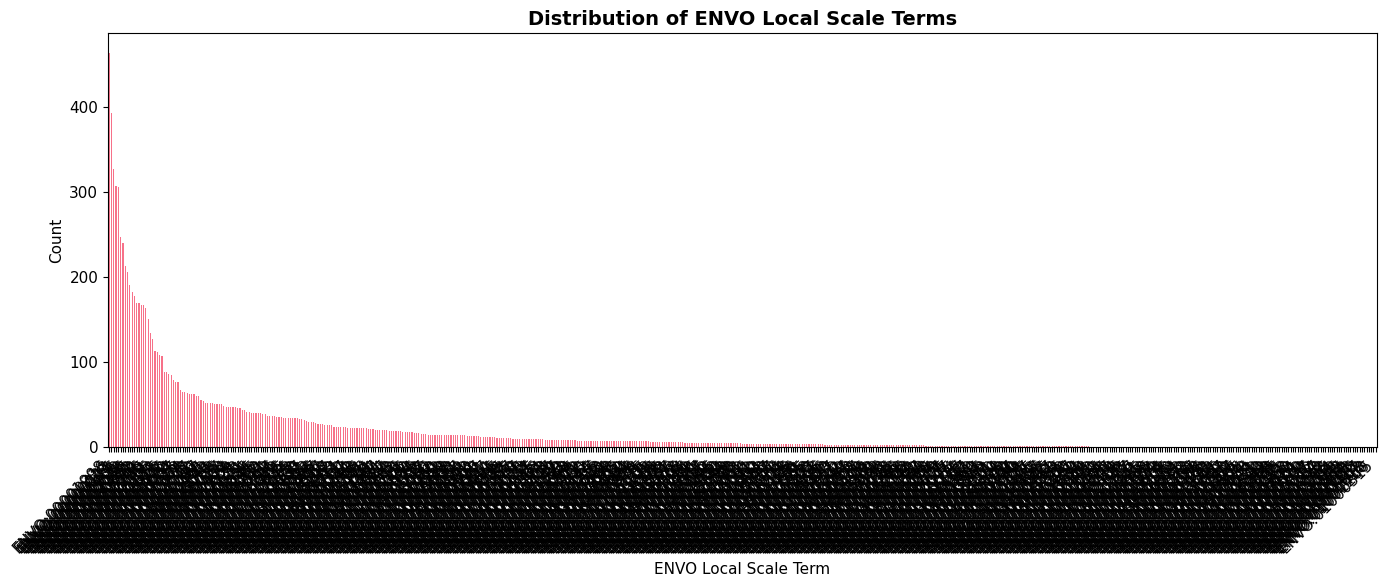


Class balance analysis:
Most common class: 464 samples (4.2%)
Least common class: 1 samples (0.0%)


In [6]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(14, 6))
value_counts.plot(kind='bar', ax=ax)
ax.set_title('Distribution of ENVO Local Scale Terms', fontsize=14, fontweight='bold')
ax.set_xlabel('ENVO Local Scale Term')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nClass balance analysis:")
print(f"Most common class: {value_counts.iloc[0]} samples ({value_counts.iloc[0]/len(df_clean)*100:.1f}%)")
print(f"Least common class: {value_counts.iloc[-1]} samples ({value_counts.iloc[-1]/len(df_clean)*100:.1f}%)")

## Prepare Features and Labels

In [7]:
# Create feature matrix X from embeddings
X = np.vstack(df_clean['ge_embedding'].values)
print(f"Feature matrix shape: {X.shape}")

# Create target vector y
y = df_clean['env_local_scale'].values
print(f"Target vector shape: {y.shape}")

print(f"\nNumber of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

Feature matrix shape: (10978, 64)
Target vector shape: (10978,)

Number of samples: 10978
Number of features: 64
Number of classes: 553


## Train/Test Split

In [8]:
# Determine if stratification is possible
min_class_count = value_counts.min()
use_stratify = min_class_count >= 2  # Need at least 2 samples per class for stratification

print(f"Minimum class count: {min_class_count}")
print(f"Using stratified split: {use_stratify}")

# Split the data
test_size = 0.2
if use_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE
    )

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())

Minimum class count: 1
Using stratified split: False

Training set: 8782 samples
Test set: 2196 samples

Training set class distribution:
ENVO:00001998    361
ENVO:00000316    323
ENVO:00000023    268
ENVO:00000111    243
ENVO:00000114    223
                ... 
ENVO:01001495      1
ENVO:01001870      1
ENVO:01001818      1
ENVO:00002985      1
ENVO:00002874      1
Name: count, Length: 527, dtype: int64


## Train Random Forest Classifier

In [9]:
# Train Random Forest
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)
print("Training complete!")

Training Random Forest Classifier...
Training complete!


## Model Evaluation

In [10]:
# Make predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=== MODEL PERFORMANCE ===")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"\nDifference (overfitting check): {train_accuracy - test_accuracy:.3f}")

=== MODEL PERFORMANCE ===
Training accuracy: 0.637
Test accuracy: 0.531

Difference (overfitting check): 0.107


In [11]:
# Cross-validation on training set
if len(X_train) >= 5:  # Need enough samples for CV
    cv_folds = min(5, len(X_train))
    print(f"\n=== CROSS-VALIDATION ({cv_folds}-fold) ===")
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=cv_folds, scoring='accuracy')
    print(f"CV Accuracy scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
else:
    print("\nDataset too small for cross-validation")


=== CROSS-VALIDATION (5-fold) ===
CV Accuracy scores: [0.54240182 0.54581673 0.53246014 0.51651481 0.52562642]
Mean CV accuracy: 0.533 (+/- 0.022)


In [12]:
# Detailed classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
print(classification_report(y_test, y_test_pred, zero_division=0))


=== CLASSIFICATION REPORT (Test Set) ===
               precision    recall  f1-score   support

ENVO:00000003       0.67      0.50      0.57         4
ENVO:00000004       0.00      0.00      0.00         1
ENVO:00000011       0.00      0.00      0.00        14
ENVO:00000014       0.00      0.00      0.00         3
ENVO:00000015       1.00      0.11      0.20         9
ENVO:00000016       0.71      0.53      0.61        19
ENVO:00000020       0.57      0.85      0.69        41
ENVO:00000021       1.00      0.25      0.40         4
ENVO:00000022       1.00      0.42      0.60        33
ENVO:00000023       0.72      0.81      0.76        59
ENVO:00000025       0.00      0.00      0.00         1
ENVO:00000029       0.86      0.68      0.76        28
ENVO:00000032       0.00      0.00      0.00         8
ENVO:00000033       1.00      0.17      0.29        12
ENVO:00000035       0.00      0.00      0.00         7
ENVO:00000038       0.00      0.00      0.00         2
ENVO:00000039       0.

## Confusion Matrix

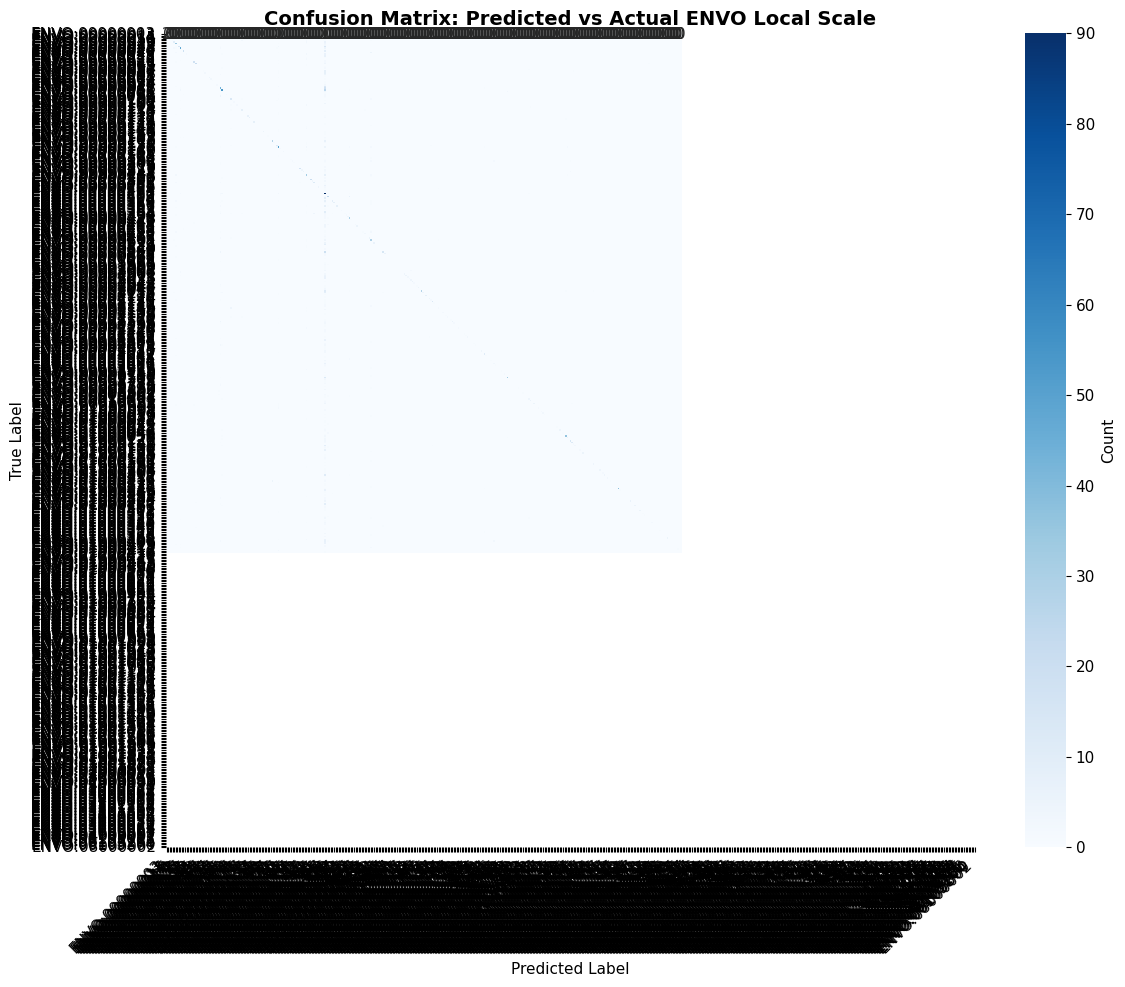

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
class_labels = rf_classifier.classes_

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix: Predicted vs Actual ENVO Local Scale', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Importance

In [14]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = [f"GE_dim_{i}" for i in range(len(feature_importances))]

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("=== TOP 20 MOST IMPORTANT FEATURES ===")
print(importance_df.head(20))

=== TOP 20 MOST IMPORTANT FEATURES ===
      feature  importance
26  GE_dim_26    0.051031
7    GE_dim_7    0.031448
25  GE_dim_25    0.029744
9    GE_dim_9    0.026249
61  GE_dim_61    0.024473
54  GE_dim_54    0.024459
42  GE_dim_42    0.024410
23  GE_dim_23    0.022451
40  GE_dim_40    0.022013
53  GE_dim_53    0.021799
16  GE_dim_16    0.020118
21  GE_dim_21    0.019901
12  GE_dim_12    0.019217
39  GE_dim_39    0.018965
31  GE_dim_31    0.018824
8    GE_dim_8    0.018725
24  GE_dim_24    0.018461
44  GE_dim_44    0.017651
57  GE_dim_57    0.017637
28  GE_dim_28    0.017428


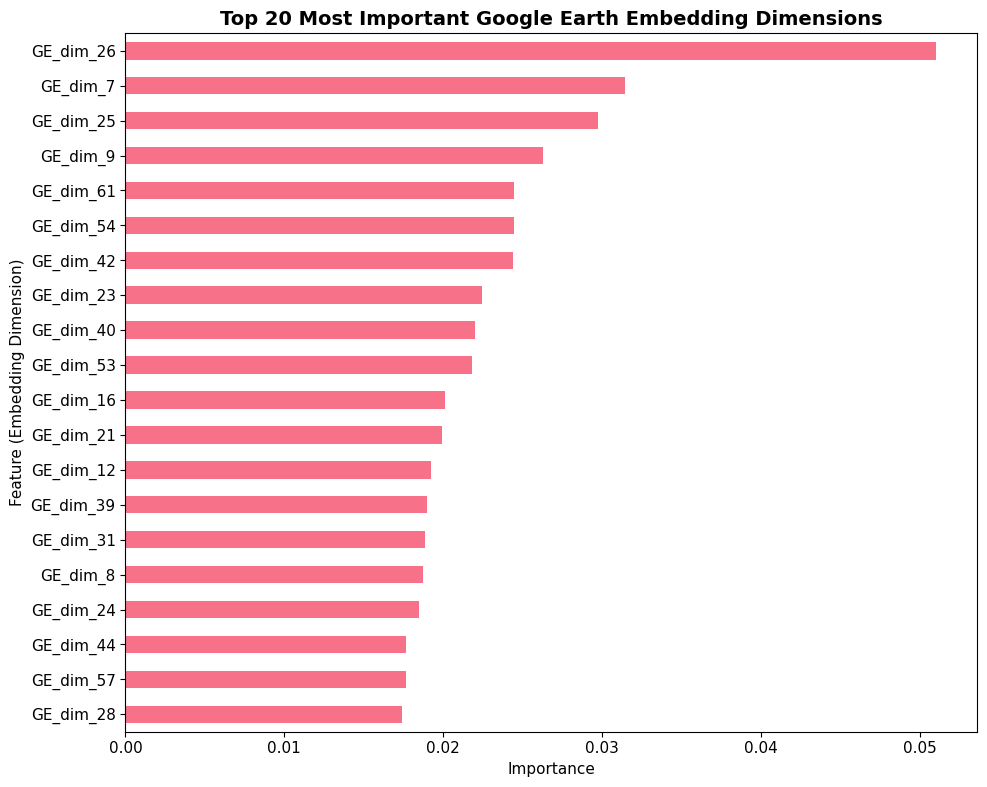

In [15]:
# Plot top 20 feature importances
top_n = 20
fig, ax = plt.subplots(figsize=(10, 8))
importance_df.head(top_n).plot(x='feature', y='importance', kind='barh', ax=ax, legend=False)
ax.set_title(f'Top {top_n} Most Important Google Earth Embedding Dimensions', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature (Embedding Dimension)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Prediction Analysis

In [16]:
# Get prediction probabilities
y_test_proba = rf_classifier.predict_proba(X_test)
max_probabilities = y_test_proba.max(axis=1)

print("=== PREDICTION CONFIDENCE ===")
print(f"Mean prediction confidence: {max_probabilities.mean():.3f}")
print(f"Std prediction confidence: {max_probabilities.std():.3f}")
print(f"Min prediction confidence: {max_probabilities.min():.3f}")
print(f"Max prediction confidence: {max_probabilities.max():.3f}")

=== PREDICTION CONFIDENCE ===
Mean prediction confidence: 0.203
Std prediction confidence: 0.246
Min prediction confidence: 0.033
Max prediction confidence: 0.996


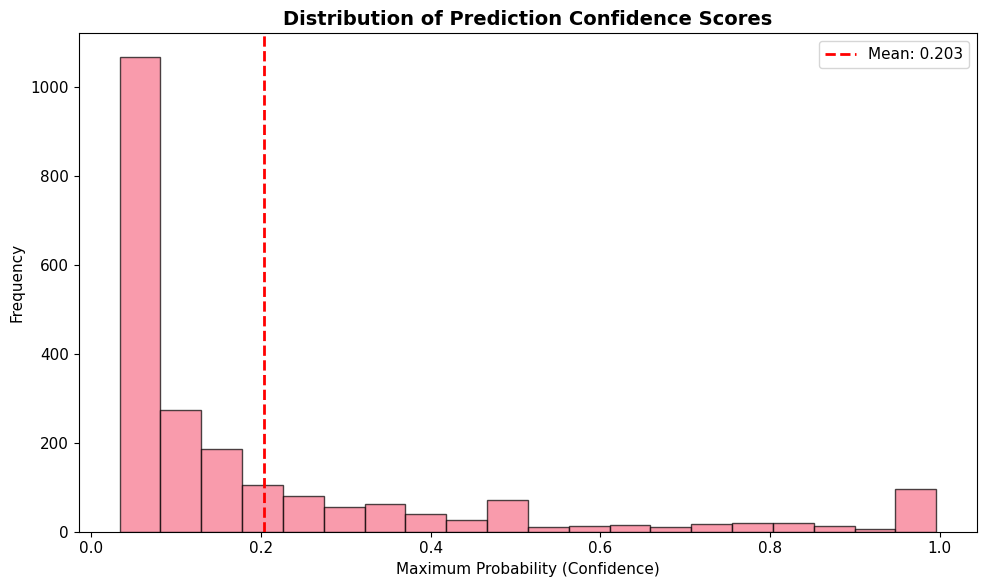

In [17]:
# Plot prediction confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(max_probabilities, bins=20, alpha=0.7, edgecolor='black')
ax.axvline(max_probabilities.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {max_probabilities.mean():.3f}')
ax.set_title('Distribution of Prediction Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Maximum Probability (Confidence)')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# Show some example predictions
print("\n=== EXAMPLE PREDICTIONS ===")
n_examples = min(10, len(y_test))
for i in range(n_examples):
    true_label = y_test[i]
    pred_label = y_test_pred[i]
    confidence = max_probabilities[i]
    correct = "✓" if true_label == pred_label else "✗"
    print(f"\n{correct} Sample {i+1}:")
    print(f"  True: {true_label}")
    print(f"  Predicted: {pred_label} (confidence: {confidence:.3f})")


=== EXAMPLE PREDICTIONS ===

✗ Sample 1:
  True: ENVO:00000109
  Predicted: ENVO:00001998 (confidence: 0.066)

✓ Sample 2:
  True: ENVO:00000316
  Predicted: ENVO:00000316 (confidence: 0.217)

✓ Sample 3:
  True: ENVO:00000023
  Predicted: ENVO:00000023 (confidence: 0.707)

✓ Sample 4:
  True: ENVO:00002173
  Predicted: ENVO:00002173 (confidence: 0.059)

✗ Sample 5:
  True: ENVO:01000352
  Predicted: ENVO:00001998 (confidence: 0.057)

✓ Sample 6:
  True: ENVO:01000892
  Predicted: ENVO:01000892 (confidence: 0.049)

✗ Sample 7:
  True: ENVO:00000304
  Predicted: ENVO:01000002 (confidence: 0.060)

✓ Sample 8:
  True: ENVO:00001998
  Predicted: ENVO:00001998 (confidence: 0.061)

✓ Sample 9:
  True: ENVO:00000111
  Predicted: ENVO:00000111 (confidence: 0.059)

✓ Sample 10:
  True: ENVO:00005742
  Predicted: ENVO:00005742 (confidence: 0.165)


## Summary and Conclusions

In [19]:
print("=== EXPERIMENT SUMMARY ===")
print(f"\nDataset:")
print(f"  - Total samples: {len(df_clean)}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Number of classes: {len(np.unique(y))}")
print(f"  - Feature dimensions: {X.shape[1]}")

print(f"\nModel:")
print(f"  - Algorithm: Random Forest Classifier")
print(f"  - Number of trees: {rf_classifier.n_estimators}")
print(f"  - Max depth: {rf_classifier.max_depth}")

print(f"\nPerformance:")
print(f"  - Training accuracy: {train_accuracy:.3f}")
print(f"  - Test accuracy: {test_accuracy:.3f}")
print(f"  - Mean prediction confidence: {max_probabilities.mean():.3f}")

print(f"\nKey Findings:")
if test_accuracy > 0.7:
    print("  ✓ Google Earth embeddings show STRONG predictive power for ENVO local scale")
elif test_accuracy > 0.5:
    print("  ~ Google Earth embeddings show MODERATE predictive power for ENVO local scale")
else:
    print("  ✗ Google Earth embeddings show LIMITED predictive power for ENVO local scale")

if train_accuracy - test_accuracy > 0.2:
    print("  ⚠ Significant overfitting detected - model may not generalize well")
elif train_accuracy - test_accuracy > 0.1:
    print("  ⚠ Moderate overfitting - consider regularization")
else:
    print("  ✓ Good generalization - minimal overfitting")

=== EXPERIMENT SUMMARY ===

Dataset:
  - Total samples: 10978
  - Training samples: 8782
  - Test samples: 2196
  - Number of classes: 553
  - Feature dimensions: 64

Model:
  - Algorithm: Random Forest Classifier
  - Number of trees: 100
  - Max depth: 10

Performance:
  - Training accuracy: 0.637
  - Test accuracy: 0.531
  - Mean prediction confidence: 0.203

Key Findings:
  ~ Google Earth embeddings show MODERATE predictive power for ENVO local scale
  ⚠ Moderate overfitting - consider regularization
